In [1]:
import json
import pickle
import re
import collections
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
from random import randint
import sys
import math
from scipy import spatial,sparse
import random

%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
path_test2 = 'C:\\Users\\chenwang\\Documents\\courses\\FA16\\CS597\\twitterMining\\InitialSet\\Football\\location\\test2\\'
ff_path = path_test2 +'ff_of_rep\\'

In [6]:
# vocabulary?
filenames = [f for f in listdir(ff_path) if isfile(join(ff_path, f))]

In [8]:
def sample_from_candidates(ff_path, filenames,seed):
    
    candidate_sp = []  # use this to test my PLSA model
    random.seed(seed)
    
    for file in filenames:
        try:
            with open(ff_path + file,'rb') as f:
                candidate = pickle.load(f)

                # too big to process, sampling 100 followers from each representative nodes
                for c in random.sample(set(candidate),100):
                    if c not in candidate_sp:
                        candidate_sp.append(c)

        except EOFError:
            print(file)
            pass
        
    return candidate_sp

In [11]:
with open(path_test2 + 'candidate_sp1.pickle','rb') as f:
    candidate_sp1 = pickle.load(f)
with open(path_test2 + 'candidate_sp2.pickle','rb+') as f:
    candidate_sp2 = pickle.load(f)
with open(path_test2 + 'represent_id.pickle','rb') as f:
    feature = pickle.load(f)

# construct a vector

In [12]:
def construct_vector(candidate_list,feature):
    
    V = dict((c,np.zeros(len(feature),)) for c in candidate_list)

    for i in range(len(feature)):  
        with open(ff_path + str(feature[i]) + '.pickle','rb') as f:

                candidate = pickle.load(f)

                for c in candidate:
                    if c in V.keys():
                        #print('true')
                        V[c][i] = 1 
    return V

In [13]:
Vector1 = construct_vector(candidate_sp1,feature)
Vector2 = construct_vector(candidate_sp2,feature)
# Vector3 = construct_vector(candidate_sp3,feature)

# test block to see how sparse the matrix is

In [14]:
def test_sparsity(V,feature_num):
    for v in list(V.keys()):
        total_feature = np.sum(V[v])
        if total_feature >= feature_num:
            print('user_id:', v,'\t\ttotal feature:', total_feature)
    return None

In [16]:
test_sparsity(Vector1,40)
test_sparsity(Vector2,40)
#test_sparsity(Vector3,40)

user_id: 779659530242142208 		total feature: 48.0
user_id: 774698932098117632 		total feature: 50.0
user_id: 4329587333 		total feature: 46.0
user_id: 724324687040258048 		total feature: 43.0
user_id: 26548315 		total feature: 45.0
user_id: 4856267962 		total feature: 40.0
user_id: 717193709612191745 		total feature: 55.0
user_id: 49924687 		total feature: 43.0
user_id: 738473536210231297 		total feature: 43.0
user_id: 2233749085 		total feature: 41.0
user_id: 718112741806837760 		total feature: 42.0
user_id: 747176409131454464 		total feature: 44.0
user_id: 773310965609799680 		total feature: 42.0
user_id: 3902248648 		total feature: 50.0
user_id: 550557628 		total feature: 44.0
user_id: 167139611 		total feature: 44.0
user_id: 3632241072 		total feature: 49.0
user_id: 751781151564529665 		total feature: 49.0
user_id: 771495164699250688 		total feature: 43.0
user_id: 4422065969 		total feature: 45.0
user_id: 4708835841 		total feature: 47.0
user_id: 784182080204894208 		total feature:

# Build Classifier
<img src=untitled.png>

In [17]:
with open(path_test2 + 'prob_following_rep.pickle','rb') as f:
    prob = pickle.load(f)

In [18]:
with open(path_test2 + 'prob_following_rep.pickle','rb') as f:
    vxy = pickle.load(f)

In [19]:
def NB_rank_candidate(V, feature, probability, penalty=True):
    
    candidate_score = {}

    for v in list(V.keys()):  # for each user
        
        score = 0
        for i in range(len(feature)): # for each feature            

            if V[v][i] == 1:  # if follow
                score += math.log2(probability[0][i]) # ln(p(follow)) 
                
            if penalty == True:
                if V[v][i] == 0:
                    score += math.log2(probability[1][i]) # ln(p(unfollow))

        candidate_score[v] = score
    
    NB_candidate_score = sorted(candidate_score.items(),key=lambda x:x[1],reverse=True)
    
    return NB_candidate_score

In [21]:
NB_p_rank_sp1 = NB_rank_candidate(Vector1, feature, prob, penalty=True)
NB_p_rank_sp2 = NB_rank_candidate(Vector2, feature, prob, penalty=True)
with open (path_test2 + 'NB_p_rank_sp1.pickle', 'wb+') as f:
    pickle.dump(NB_p_rank_sp1,f)
with open (path_test2 + 'NB_p_rank_sp2.pickle', 'wb+') as f:
    pickle.dump(NB_p_rank_sp2,f)

In [22]:
NB_rank_sp1 = NB_rank_candidate(Vector1, feature,prob, penalty=False)
NB_rank_sp2 = NB_rank_candidate(Vector2, feature,prob, penalty=False)
with open (path_test2 + 'NB_rank_sp1.pickle', 'wb+') as f:
    pickle.dump(NB_rank_sp1,f)
with open (path_test2 + 'NB_rank_sp2.pickle', 'wb+') as f:
    pickle.dump(NB_rank_sp2,f)

In [23]:
def plot_ranks(rank,Vector,title,fname):
    
    n_f = []  # total number of features
    for c in rank:
        n_f.append(np.sum(Vector[c[0]]))

    x = range(1,len(n_f)+1)
    y = n_f

    fig, axes = plt.subplots(figsize=(6,6))

    axes.plot(x,y)
    axes.set_xlabel('ranked candidate ' + str(len(rank)))
    axes.set_ylabel('total number of feature')
    axes.set_title(title, fontsize = 20)
    #axes.set_ylim([1,40])
    #axes.set_xlim([0,30000])

    plt.show()
    
    #fig = plt.figure()
    fig.savefig(fname)

    return None

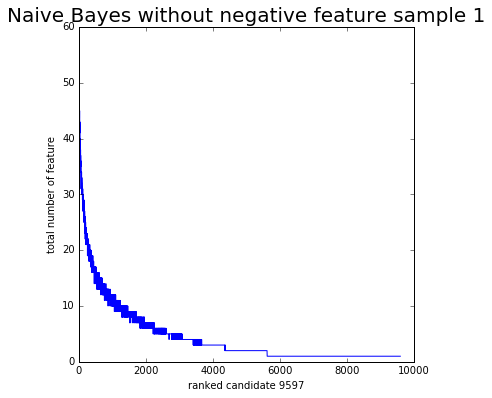

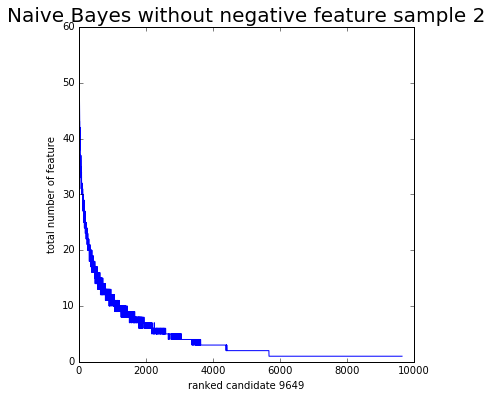

In [24]:
plot_ranks(NB_rank_sp1,Vector1,'Naive Bayes without negative feature sample 1', path_test2+'NB_feature_sp1.png')
plot_ranks(NB_rank_sp2,Vector2,'Naive Bayes without negative feature sample 2', path_test2+'NB_feature_sp2.png')

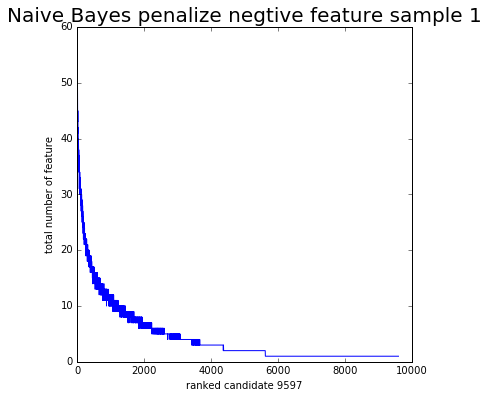

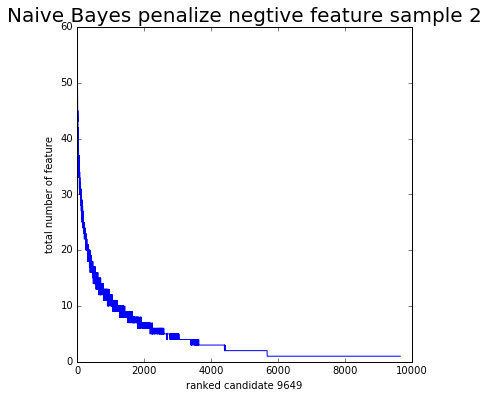

In [25]:
plot_ranks(NB_p_rank_sp1,Vector1,'Naive Bayes penalize negtive feature sample 1', path_test2+'NB_p_feature_sp1.png')
plot_ranks(NB_p_rank_sp2,Vector2,'Naive Bayes penalize negtive feature sample 2', path_test2+'NB_p_feature_sp2.png')

# Vector space model approach
similarity = cosine similarity?


In [26]:
with open(path_test2 + 'weight_rep.pickle','rb') as f:
    weight_vector = pickle.load(f)

In [27]:
def cosine_similarity(V, weight):
    similarity = {}
    feature_vector = np.ones((1,100))
    #print(feature_vector)
                      
    for v in list(V.keys()):  # for each user
        if weight != None:
            V_weighted = np.multiply(V[v],weight_vector)
            similarity[v] = 1 - spatial.distance.cosine(V_weighted, weight)
        else:
            similarity[v] = 1 - spatial.distance.cosine(V[v],feature_vector)

    sim_ranked = sorted(similarity.items(),key=lambda x:x[1],reverse=True)
    
    return sim_ranked

In [28]:
w_sim_rank_sp1 = cosine_similarity(Vector1, weight_vector)
w_sim_rank_sp2 = cosine_similarity(Vector2, weight_vector)
sim_rank_sp1 = cosine_similarity(Vector1,None)
sim_rank_sp2 = cosine_similarity(Vector2,None)

In [29]:
with open(path_test2 + 'weighted_sim_rank_sp1.pickle','wb+') as f:
    pickle.dump(w_sim_rank_sp1,f)
with open(path_test2 + 'weighted_sim_rank_sp2.pickle','wb+') as f:
    pickle.dump(w_sim_rank_sp2,f)
    
with open(path_test2 + 'unweighted_sim_rank_sp1.pickle','wb+') as f:
    pickle.dump(sim_rank_sp1,f)
with open(path_test2 + 'unweighted_sim_rank_sp2.pickle','wb+') as f:
    pickle.dump(sim_rank_sp2,f)    

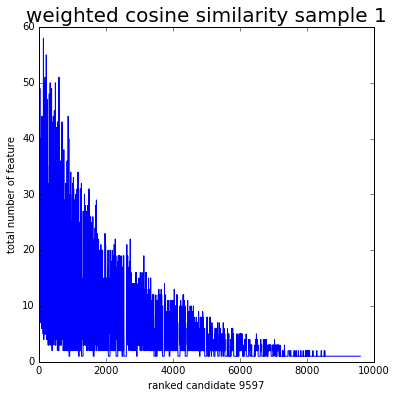

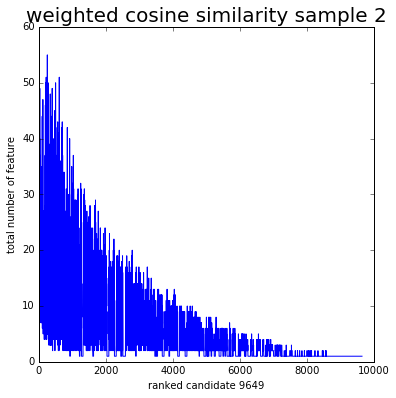

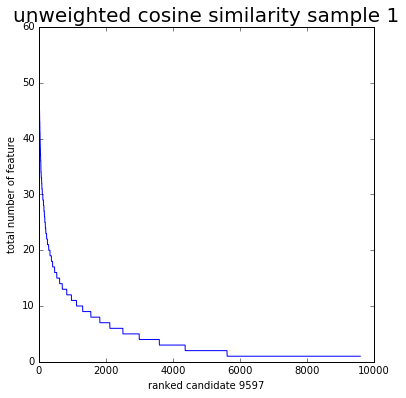

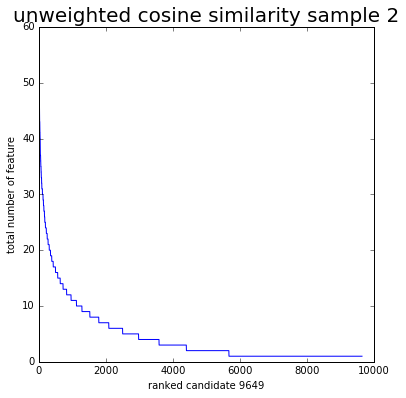

In [30]:
plot_ranks(w_sim_rank_sp1,Vector1,'weighted cosine similarity sample 1', path_test2+'w_feature_sp1.png')
plot_ranks(w_sim_rank_sp2,Vector2,'weighted cosine similarity sample 2', path_test2+'w_feature_sp2.png')
plot_ranks(sim_rank_sp1,Vector1,'unweighted cosine similarity sample 1', path_test2+'u_feature_sp1.png')
plot_ranks(sim_rank_sp2,Vector2,'unweighted cosine similarity sample 2', path_test2+'u_feature_sp2.png')

In [31]:
candidate_sp1[0]

16118854